In [98]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis

from ydata_profiling import ProfileReport

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr, ttest_ind
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns


Load Quality Control Data

In [2]:
via11_scQA = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/QA_centralSulcus_lkj.xlsx')[['subjects', 'sites', 'vis_QA', 'editted']]
via11_scQA = via11_scQA[~via11_scQA.subjects.isna()]
via11_scQA = via11_scQA.set_index('subjects')

Load Demographic Data and GT and Match with QC Data

In [3]:
via11_demo = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
via11_demo = via11_demo[via11_demo.mp2rage_exists == 1].drop(columns=['in_via11', 'stormdb'])
via11_demo['subjects'] = [f'sub-via{x:03d}' for x in via11_demo.via_id]
via11_demo = via11_demo[~via11_demo.subjects.isna()]
via11_demo = via11_demo[via11_demo.subjects.isin(via11_scQA.index.values)]
via11_demo = via11_demo.set_index('subjects')

for subject in via11_demo.index.values:
    # via11_demo.loc[subject, 'site'] = via11_scQA.loc[subject, 'sites']
    via11_demo.loc[subject, 'vis_QA'] = via11_scQA.loc[subject, 'vis_QA']
    via11_demo.loc[subject, 'editted'] = via11_scQA.loc[subject, 'editted']

In [4]:
via11_demo

,via_id,site,group,mri_age,sex,handedness,tanner,cbcl_total,cbcl_external,cbcl_internal,...,flanker_behav_deltaRT_3sd,no_sMRI,no_flanker_fMRI,Braces,neurological disorder,in_flanker_behav,in_flanker_analysis,comment,vis_QA,editted
subjects,,,,,,,,,,,,,,,,,,,,,
sub-via003,3,1.0,3.0,12.188912,0.0,3.0,2.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
sub-via004,4,1.0,3.0,11.764545,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,1.0,0.0
sub-via005,5,1.0,3.0,11.493498,0.0,3.0,2.0,9.0,2.0,3.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,1.0,0.0
sub-via010,10,2.0,2.0,11.718001,1.0,2.0,2.0,62.0,14.0,13.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,2.0,1.0
sub-via013,13,2.0,3.0,12.287474,0.0,2.0,3.0,7.0,2.0,2.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-via517,517,2.0,3.0,11.641342,1.0,3.0,3.0,4.0,0.0,3.0,...,0.0,1.0,1.0,0,0,0.0,0.0,stim. Com. Malfunction,1.0,0.0
sub-via518,518,1.0,3.0,12.353183,1.0,3.0,2.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
sub-via519,519,2.0,3.0,12.533881,1.0,3.0,4.0,11.0,2.0,3.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0


It contains the group they belong to in column E (1; FHR-BP, 2; FHR-SZ, 3; control). It also contains age (at MRI) and sex (0; female, 1; male) in column F and G, respectively. Column H states their handedness (1; left, 2; ambidextrous, 3; right)

In this sheet you will also find their behavioral problem score (cbcl; column J through L) and a global functioning score (cgas; column M) as well as information on whether or not the child has a psychiatric diagnosis (axis-1) already (column N - 1; yes, 0; no). The rest of the columns are irrelevant for you. 

I've written the following to explain diagnosis, cbcl, cgas and handedness:
"Presence of any past or present Axis-I diagnoses was based on the semi-structured diagnostic interview Schedule for Affective Disorders and Schizophrenia for School-Age Children-Present and Lifetime Version (K-SADS-PL). The interview was administered by trained personnel with the child and the primary caregiver. Diagnoses were based on the Diagnostic and Statistical Manual of Mental Disorders (DSM)-IV and DSM-5 Axis-I disorders. Details on the Axis-I diagnoses present in this cohort have been published elsewhere (5). The children’s level of behavioral problems was assessed with the Child Behavior Check List (CBCL), School-Age version (6). For CBCL we used the two broad-band subscales (Internalizing and Externalizing) as well as the total score as clinical measures of the children’s problem behavior. The questionnaire was completed by the primary caregiver. The primary caregiver was carefully chosen to be the adult knowing the child the best and was, preferably, living with the child. Higher scores on CBCL indicate more problem behavior. Global functioning was assessed with the Children’s Global Assessment Scale (CGAS, (7)). Higher scores on CGAS indicate higher global levels of functioning. The CGAS was completed as part of the K-SADS-PL by trained researchers interviewing the child and the primary caregiver. Handedness was determined with the Edinburgh Handedness Inventory (EHI) (8) and characterized as right-handed, left-handed, or ambidextrous according to the obtained laterality quotient (LQ) score; -100 to -50, -50 to 50 and 50 to 100, respectively."

Load CS features

In [5]:
via11_demo.columns

Index(['via_id', 'site', 'group', 'mri_age', 'sex', 'handedness', 'tanner',
       'cbcl_total', 'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis',
       'mri_any_test', 'fmri_exists', 'pa1_exists', 'fmri_phys', 'mpr_exists',
       'mp2rage_exists', 'mpr_type_analysis', 't1_anomali', 'mpr_vqc_bad',
       'mpr_qqc_bad', 'mpr2_vqc_bad', 'mpr2_qqc_bad', 'fmri_vqc_bad',
       'fmri_qqc_bad', 'flanker_behav_software_error',
       'flanker_behav_omm_error_30p', 'flanker_behav_com_error_30p',
       'flanker_behav_incon_3sd', 'flanker_behav_deltaRT_3sd', 'no_sMRI',
       'no_flanker_fMRI', 'Braces', 'neurological disorder',
       'in_flanker_behav', 'in_flanker_analysis', 'comment', 'vis_QA',
       'editted'],
      dtype='object')

In [6]:
cs_feat = pd.read_pickle('../data/bvisa_subject_features.pkl')

In [7]:
cs_feat['sub-via003'].keys()

dict_keys(['morphology', 'depth_profile_L', 'depth_profile_R', 'medial_axis_L', 'medial_axis_R'])

In [8]:
def select_morphofeatures(df:pd.DataFrame,
                          features:list[str] = ['label',
                                                'side',
                                                'surface_talairach',
                                                'maxdepth_talairach',
                                                'meandepth_talairach',
                                                'hull_junction_length_talairach',
                                                'GM_thickness', 'opening'], 
                          sulci: list[str] = ['S.C.'],
                          side: str = 'r'):
    """_summary_

    Args:
        df (pd.DataFrame): DataFrame with morphological features of a subject
        features (list[str], optional): List of features to use. Defaults to ['label', 'side', 'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach'].
        sulci (list[str], optional): List of sulci to use. Defaults to ['S.C.'].
        side (str, optional): Which sides of sulci to use as features.
            Could be 'l' or 'r' to extract features only from left or right
            sulci or 'both' to extract features from both. Defaults to 'r'.

    Returns:
        np.ndarray: 1D array of features
        np.ndarray: 1D array of feature names
    """
    # filter by selected sulci
    features = df[df.label.isin(sulci)][features]
    if len(sulci) == 1:
        features = features.drop(columns=['label'])
    else:
        raise NotImplementedError('Only one sulcus is supported for now')
    
    # get feature names
    if side == 'l' or side =='r':
        feature_names = [f'{side}_{c}' for c in features.columns.values]
    else:
        feature_names = [f'{s}_{c}' for s in ['l', 'r']  for c in features.columns.values if c != 'side']
    
    # transform features into an array
    if side == 'l':
        features = features[features.side == 'left'].drop(columns=['side'])
    elif side == 'r':
        features = features[features.side == 'right'].drop(columns=['side'])
    elif side == 'both':
        features = features.drop(columns=['side'])
    else:
        raise ValueError('side should be either "l", "r" or "both"')
    features = features.values.flatten()
    
    
    return features, feature_names
    

In [9]:
cs_feat['sub-via003']['morphology']

,sulcus,label,side,surface_talairach,surface_native,maxdepth_talairach,maxdepth_native,meandepth_talairach,meandepth_native,hull_junction_length_talairach,hull_junction_length_native,GM_thickness,opening
0,F.C.L.a._left,F.C.L.a.,left,2502.56,2325.31,23.94,23.16,18.54,17.88,67.72,65.40,4.61,1.26
1,F.C.L.a._right,F.C.L.a.,right,2112.10,1964.46,15.80,15.24,8.33,8.07,88.50,85.52,5.02,1.80
2,F.C.L.p._left,F.C.L.p.,left,6459.86,6018.04,43.62,42.50,20.20,19.66,132.00,126.72,4.06,1.40
3,F.C.L.p._right,F.C.L.p.,right,6573.63,6127.98,26.20,25.54,14.08,13.65,153.80,147.56,4.12,0.91
4,F.C.L.r.ant._left,F.C.L.r.ant.,left,480.00,446.59,24.04,23.36,13.52,13.12,11.64,11.18,4.53,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,S.T.s.ter.asc.post._right,S.T.s.ter.asc.post.,right,1620.64,1512.60,23.10,22.46,15.17,14.72,57.98,55.84,4.39,0.64
119,S.p.C._left,S.p.C.,left,357.18,332.74,12.54,12.22,7.24,7.06,25.38,24.30,4.41,1.18
120,S.p.C._right,S.p.C.,right,288.81,268.76,8.06,7.86,5.00,4.88,34.84,33.44,4.67,2.00
121,S.s.P._left,S.s.P.,left,1303.80,1215.75,17.52,17.06,8.56,8.34,76.18,73.02,4.25,0.49


In [10]:
select_morphofeatures(cs_feat['sub-via003']['morphology'], side='both')

(array([4.35389e+03, 2.72200e+01, 1.74400e+01, 1.31680e+02, 3.54000e+00,
        1.07000e+00, 4.47070e+03, 2.59200e+01, 1.57200e+01, 1.53660e+02,
        3.55000e+00, 1.27000e+00]),
 ['l_surface_talairach',
  'l_maxdepth_talairach',
  'l_meandepth_talairach',
  'l_hull_junction_length_talairach',
  'l_GM_thickness',
  'l_opening',
  'r_surface_talairach',
  'r_maxdepth_talairach',
  'r_meandepth_talairach',
  'r_hull_junction_length_talairach',
  'r_GM_thickness',
  'r_opening'])

In [11]:
cs_feat['sub-via003']['morphology'][cs_feat['sub-via003']['morphology']['label'] =='S.C.']#[['label', 'side', 'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach', 'hull_junction_length_talairach', 'GM_thickness', 'opening']]

,sulcus,label,side,surface_talairach,surface_native,maxdepth_talairach,maxdepth_native,meandepth_talairach,meandepth_native,hull_junction_length_talairach,hull_junction_length_native,GM_thickness,opening
40,S.C._left,S.C.,left,4353.89,4039.42,27.22,26.32,17.44,16.82,131.68,127.16,3.54,1.07
41,S.C._right,S.C.,right,4470.70,4151.93,25.92,25.06,15.72,15.19,153.66,148.14,3.55,1.27


In [12]:
cs_feat['sub-via003']['morphology']['label'].values

array(['F.C.L.a.', 'F.C.L.a.', 'F.C.L.p.', 'F.C.L.p.', 'F.C.L.r.ant.',
       'F.C.L.r.ant.', 'F.C.L.r.asc.', 'F.C.L.r.asc.', 'F.C.L.r.diag.',
       'F.C.L.r.diag.', 'F.C.L.r.retroC.tr.', 'F.C.L.r.retroC.tr.',
       'F.C.L.r.sc.ant.', 'F.C.L.r.sc.ant.', 'F.C.L.r.sc.post.',
       'F.C.L.r.sc.post.', 'F.C.M.ant.', 'F.C.M.ant.', 'F.C.M.post.',
       'F.C.M.post.', 'F.Cal.ant.-Sc.Cal.', 'F.Cal.ant.-Sc.Cal.',
       'F.Coll.', 'F.Coll.', 'F.I.P.Po.C.inf.', 'F.I.P.Po.C.inf.',
       'F.I.P.', 'F.I.P.', 'F.I.P.r.int.1', 'F.I.P.r.int.1',
       'F.I.P.r.int.2', 'F.I.P.r.int.2', 'F.P.O.', 'F.P.O.', 'INSULA',
       'INSULA', 'OCCIPITAL', 'OCCIPITAL', 'S.C.LPC.', 'S.C.LPC.', 'S.C.',
       'S.C.', 'S.C.sylvian.', 'S.C.sylvian.', 'S.Call.', 'S.Call.',
       'S.Cu.', 'S.Cu.', 'S.F.inf.', 'S.F.inf.', 'S.F.inf.ant.',
       'S.F.inf.ant.', 'S.F.int.', 'S.F.int.', 'S.F.inter.', 'S.F.inter.',
       'S.F.marginal.', 'S.F.marginal.', 'S.F.median.', 'S.F.median.',
       'S.F.orbitaire.', 'S.F.orbi

### Extract Factor Analysis Components for the CS features of the depth and profile

In [13]:
medial_axis_L_depth_matrix = np.stack([cs_feat[x]['medial_axis_L']['depth'].values for x in cs_feat.keys()])
medial_axis_R_depth_matrix = np.stack([cs_feat[x]['medial_axis_R']['depth'].values for x in cs_feat.keys()])
depth_profile_L_depth_matrix = np.stack([cs_feat[x]['depth_profile_L']['depth'].values for x in cs_feat.keys()])
depth_profile_R_depth_matrix = np.stack([cs_feat[x]['depth_profile_R']['depth'].values for x in cs_feat.keys()])

medial_axis_L_profile_matrix = np.stack([cs_feat[x]['medial_axis_L']['profile'].values for x in cs_feat.keys()])
medial_axis_R_profile_matrix = np.stack([cs_feat[x]['medial_axis_R']['profile'].values for x in cs_feat.keys()])
depth_profile_L_profile_matrix = np.stack([cs_feat[x]['depth_profile_L']['profile'].values for x in cs_feat.keys()])
depth_profile_R_profile_matrix = np.stack([cs_feat[x]['depth_profile_R']['profile'].values for x in cs_feat.keys()])


In [14]:
FA_number_components = 3

fa = FactorAnalysis(n_components=FA_number_components) # OR CHANGE TO PCA
medial_axis_L_depth_fa = fa.fit_transform(medial_axis_L_depth_matrix)
medial_axis_R_depth_fa = fa.fit_transform(medial_axis_R_depth_matrix)
depth_profile_L_depth_fa = fa.fit_transform(depth_profile_L_depth_matrix)
depth_profile_R_depth_fa = fa.fit_transform(depth_profile_R_depth_matrix)
medial_axis_L_profile_fa = fa.fit_transform(medial_axis_L_profile_matrix)
medial_axis_R_profile_fa = fa.fit_transform(medial_axis_R_profile_matrix)
depth_profile_L_profile_fa = fa.fit_transform(depth_profile_L_profile_matrix)
depth_profile_R_profile_fa = fa.fit_transform(depth_profile_R_profile_matrix)


In [15]:
morph_feat = pd.DataFrame(np.stack([select_morphofeatures(cs_feat[x]['morphology'], side='both')[0] for x in cs_feat.keys()]),
                          columns=select_morphofeatures(cs_feat['sub-via003']['morphology'], side='both')[1], index=[x for x in cs_feat.keys()])

profile_feat = {'L_medial_axis_depth':medial_axis_L_depth_fa,
                'R_medial_axis_depth':medial_axis_R_depth_fa,
                'L_depth_profile_depth':depth_profile_L_depth_fa,
                'R_depth_profile_depth':depth_profile_R_depth_fa,
                'L_medial_axis_profile':medial_axis_L_profile_fa,
                'R_medial_axis_profile':medial_axis_R_profile_fa,
                'L_depth_profile_profile':depth_profile_L_profile_fa,
                'R_depth_profile_profile':depth_profile_R_profile_fa,
            }

for f in profile_feat.keys():
    for fnum in range(FA_number_components):
        morph_feat[f'{f}_{fnum}'] = profile_feat[f][:, fnum]

morph_feat

,l_surface_talairach,l_maxdepth_talairach,l_meandepth_talairach,l_hull_junction_length_talairach,l_GM_thickness,l_opening,r_surface_talairach,r_maxdepth_talairach,r_meandepth_talairach,r_hull_junction_length_talairach,...,L_medial_axis_profile_2,R_medial_axis_profile_0,R_medial_axis_profile_1,R_medial_axis_profile_2,L_depth_profile_profile_0,L_depth_profile_profile_1,L_depth_profile_profile_2,R_depth_profile_profile_0,R_depth_profile_profile_1,R_depth_profile_profile_2
sub-via010,4654.97,26.08,15.74,153.68,3.19,1.52,4770.65,29.64,18.01,140.80,...,1.272058,0.210030,-1.507214,1.193666,-0.067766,-0.421201,-0.142746,0.764889,-0.251837,-0.380660
sub-via013,4970.43,26.10,14.84,162.60,3.55,1.31,4420.30,25.76,15.56,149.12,...,0.452145,0.537220,-0.279126,1.020682,-0.052377,-0.404858,-1.610197,-1.072281,0.099128,-0.803938
sub-via014,5519.48,29.36,18.11,163.70,3.35,1.48,4434.51,24.80,12.99,173.74,...,0.709835,-0.396973,2.542791,-0.245381,-0.482622,-0.812200,2.526079,1.331830,-1.520562,0.094663
sub-via015,3924.83,27.14,15.94,127.48,3.21,1.47,5104.05,30.00,16.38,152.44,...,-0.895849,-0.456355,0.734113,-0.825945,-0.329500,0.554087,0.450546,0.556988,-0.695754,0.184619
sub-via017,4649.19,24.90,16.47,161.12,3.43,1.09,2924.92,29.12,17.40,93.08,...,-0.021624,1.382382,-0.287213,-0.093011,-0.073018,0.292105,-0.605114,-1.983614,-2.565175,-0.371005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-via504,4517.54,27.92,17.81,140.60,3.73,1.08,5203.21,28.52,18.35,154.38,...,-0.007446,0.377691,0.026897,-0.797285,0.000954,0.644530,0.822537,-1.364558,-0.454438,0.802617
sub-via508,4450.83,30.52,16.77,147.36,3.78,0.83,4521.78,29.84,17.38,128.26,...,2.968250,-1.992372,-0.836539,0.657778,-0.006785,-3.152222,0.137956,2.569006,0.714241,-0.284817
sub-via509,4771.94,28.34,17.92,148.24,3.43,1.00,4439.18,28.38,15.84,130.94,...,0.458201,-1.706536,-1.671429,1.610044,0.111230,0.431586,-0.031683,-1.601982,-0.684814,0.806160
sub-via518,4262.19,26.94,16.59,134.74,3.55,1.06,4104.69,26.80,16.58,131.54,...,0.602137,-2.559356,-2.509624,0.129451,-0.020099,0.068693,0.681228,0.537733,1.979009,-0.705767


In [16]:
TARGET_FEAT = ['handedness', 'group', 'cbcl_total', 'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis']
target_df = via11_demo[TARGET_FEAT]
target_df

,handedness,group,cbcl_total,cbcl_external,cbcl_internal,cgas,any_diagnosis
subjects,,,,,,,
sub-via003,3.0,3.0,4.0,1.0,1.0,91.0,0.0
sub-via004,3.0,3.0,0.0,0.0,0.0,71.0,0.0
sub-via005,3.0,3.0,9.0,2.0,3.0,80.0,0.0
sub-via010,2.0,2.0,62.0,14.0,13.0,48.0,1.0
sub-via013,2.0,3.0,7.0,2.0,2.0,83.0,0.0
...,...,...,...,...,...,...,...
sub-via517,3.0,3.0,4.0,0.0,3.0,78.0,0.0
sub-via518,3.0,3.0,3.0,0.0,1.0,85.0,0.0
sub-via519,3.0,3.0,11.0,2.0,3.0,77.0,0.0


In [17]:
eda_df = target_df.join(morph_feat)

In [18]:
# profile = ProfileReport(eda_df, title="VIA11 CS Morphological Features", explorative=True)
# profile.to_file('./VIA11_CS_MorphEDA.html')

In [19]:
eda_df

,handedness,group,cbcl_total,cbcl_external,cbcl_internal,cgas,any_diagnosis,l_surface_talairach,l_maxdepth_talairach,l_meandepth_talairach,...,L_medial_axis_profile_2,R_medial_axis_profile_0,R_medial_axis_profile_1,R_medial_axis_profile_2,L_depth_profile_profile_0,L_depth_profile_profile_1,L_depth_profile_profile_2,R_depth_profile_profile_0,R_depth_profile_profile_1,R_depth_profile_profile_2
subjects,,,,,,,,,,,,,,,,,,,,,
sub-via003,3.0,3.0,4.0,1.0,1.0,91.0,0.0,4353.89,27.22,17.44,...,-0.882544,4.073485,-0.355884,-0.633154,-0.094356,-0.613653,0.618203,-0.005550,-0.570127,0.485782
sub-via004,3.0,3.0,0.0,0.0,0.0,71.0,0.0,4208.80,27.12,17.15,...,-0.828517,1.639425,1.331667,-1.163679,-0.153459,-0.834707,-0.364904,-0.162853,0.825700,-0.623562
sub-via005,3.0,3.0,9.0,2.0,3.0,80.0,0.0,4403.62,24.78,17.50,...,0.074889,0.691115,-0.824127,0.386710,-0.049817,-0.499630,0.370146,1.314316,1.722694,0.844911
sub-via010,2.0,2.0,62.0,14.0,13.0,48.0,1.0,4654.97,26.08,15.74,...,1.272058,0.210030,-1.507214,1.193666,-0.067766,-0.421201,-0.142746,0.764889,-0.251837,-0.380660
sub-via013,2.0,3.0,7.0,2.0,2.0,83.0,0.0,4970.43,26.10,14.84,...,0.452145,0.537220,-0.279126,1.020682,-0.052377,-0.404858,-1.610197,-1.072281,0.099128,-0.803938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-via517,3.0,3.0,4.0,0.0,3.0,78.0,0.0,4664.41,25.72,14.89,...,-0.695781,0.927170,-1.402472,0.956659,-0.230754,-0.534074,-1.209854,0.797177,0.458913,2.119300
sub-via518,3.0,3.0,3.0,0.0,1.0,85.0,0.0,4262.19,26.94,16.59,...,0.602137,-2.559356,-2.509624,0.129451,-0.020099,0.068693,0.681228,0.537733,1.979009,-0.705767
sub-via519,3.0,3.0,11.0,2.0,3.0,77.0,0.0,4217.15,26.84,16.16,...,0.025571,-1.001526,1.032383,-1.671218,0.079293,0.143480,-0.014238,2.028941,-0.913350,0.670837


In [20]:
area_vol = pd.read_pickle('../data/subj_area_vols.pkl')
features_df = eda_df.join(area_vol)

In [29]:
features_df.columns = [x.lower() for x in features_df.columns.values]

# Univariate analysis of the CS features

#### Comparison is done for two cases:
* QC approved by Line subjects (n=125)
* all subjects analyzed with BrainVISA (n=303)

#### The following features are compared:
* Left  sulci features
* Right sulci features
* Left-Right sulci features

In [30]:
QC_approved_subjects = via11_demo[via11_demo.vis_QA == 1.0].index.values


## Validating Features: Handedness

Two-tailed paired t-tests were performed to test whether the diﬀerence between right and left metrics signiﬁcantly dif- fered from zero.

In [36]:
# target_group = 'handedness'
# tg_dfs = dict()
# for tg_val in np.unique(features_df[target_group].values):
#     tg_dfs[tg_val] = features_df[features_df[target_group] == tg_val].drop(columns=TARGET_FEAT)

In [34]:
feat_pairs = set([x[2:] for x in features_df.drop(columns=TARGET_FEAT).columns])

### Difference between Left and Right Handed Individuals

In [47]:
all_featurs = features_df.drop(columns=TARGET_FEAT).columns

In [54]:
left_hand = features_df[features_df.handedness == 1] # g1
right_hand = features_df[features_df.handedness == 3] # g2


print('All subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(left_hand[feat], right_hand[feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')
        
print('QC Approved subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(left_hand[left_hand.index.isin(QC_approved_subjects)][feat],
                            right_hand[right_hand.index.isin(QC_approved_subjects)][feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')

All subjects
Feature:  r_depth_profile_depth_0 |	T-statistic:  -2.0332171471920724 with P-Value:  0.04296693128841132

Feature:  r_area_bv |	T-statistic:  2.216820215257446 with P-Value:  0.027433096160298032

Feature:  r_volume_bv |	T-statistic:  2.3589117734472627 with P-Value:  0.019010693556374095

QC Approved subjects
Feature:  l_medial_axis_depth_0 |	T-statistic:  -2.1703777988244375 with P-Value:  0.0320709914074887

Feature:  l_volume_bv |	T-statistic:  2.034084089990635 with P-Value:  0.0442849548305078



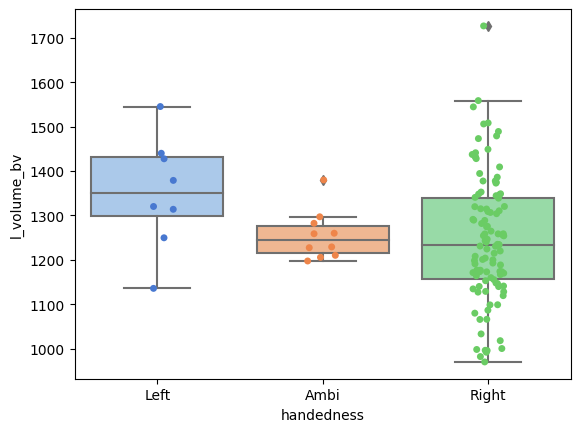

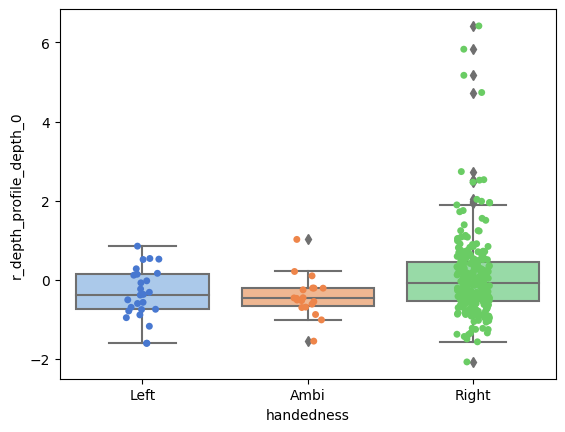

In [135]:
sns.boxplot(data=features_df[features_df.index.isin(QC_approved_subjects)], x='handedness', y='l_volume_bv', palette='pastel')
sns.stripplot(data=features_df[features_df.index.isin(QC_approved_subjects)], x='handedness', y='l_volume_bv', palette='muted')
plt.xticks([0, 1, 2], ['Left', 'Ambi', 'Right'])
plt.show()
sns.boxplot(data=features_df, x='handedness', y='r_depth_profile_depth_0', palette='pastel')
sns.stripplot(data=features_df, x='handedness', y='r_depth_profile_depth_0', palette='muted')
plt.xticks([0, 1, 2], ['Left', 'Ambi', 'Right'])
plt.show()



### Difference between Left and Right Sulci in Right Handed Individuals

In [57]:
print('All subjects')
for feat in feat_pairs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(right_hand['l_' + feat], right_hand['r_' + feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')
        
print('QC Approved subjects')
for feat in feat_pairs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(right_hand[right_hand.index.isin(QC_approved_subjects)]['l_' + feat],
                            right_hand[right_hand.index.isin(QC_approved_subjects)]['r_' + feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')

All subjects
Feature:  surface_talairach |	T-statistic:  2.8490744242100465 with P-Value:  0.0045604818990306155

QC Approved subjects


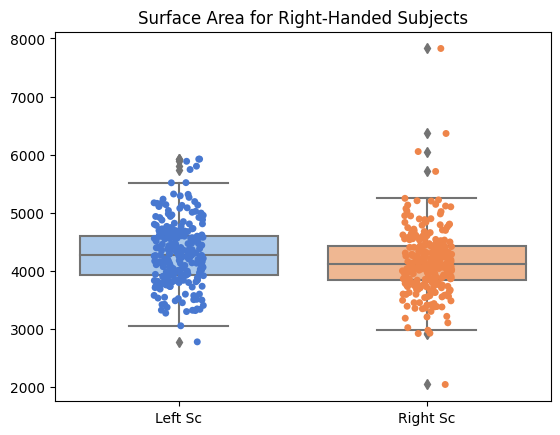

In [136]:
# sns.boxplot(data=features_df[features_df.index.isin(QC_approved_subjects)], x='handedness', y='l_medial_axis_depth_0', palette='pastel')
# sns.stripplot(data=features_df[features_df.index.isin(QC_approved_subjects)], x='handedness', y='l_medial_axis_depth_0', palette='muted')
# plt.xticks([0, 1, 2], ['Left', 'Ambi', 'Right'])
# plt.show()
sns.boxplot(data=[right_hand.l_surface_talairach.values, right_hand.r_surface_talairach.values], palette='pastel')
# sns.boxplot(data=right_hand, y='r_surface_talairach', palette='pastel')
sns.stripplot(data=[right_hand.l_surface_talairach.values, right_hand.r_surface_talairach.values], palette='muted')
plt.xticks([0, 1], ['Left Sc', 'Right Sc'])
plt.title('Surface Area for Right-Handed Subjects')
plt.show()



## FHR Group Differences

In [59]:
SZ = features_df[features_df.group == 2] # g1
BD = features_df[features_df.group == 1] # g2
CR = features_df[features_df.group == 3] # g3

#### SZ vs Control

In [137]:
print('All subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(SZ[feat], CR[feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')
        
print('QC Approved subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(SZ[SZ.index.isin(QC_approved_subjects)][feat],
                            CR[CR.index.isin(QC_approved_subjects)][feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')

All subjects
Feature:  l_depth_profile_profile_1 |	T-statistic:  -2.509108758832231 with P-Value:  0.012786742363946484

QC Approved subjects
Feature:  r_hull_junction_length_talairach |	T-statistic:  -2.106707819939069 with P-Value:  0.03762051105347776



#### BP vs Control

In [62]:
print('All subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(BD[feat], CR[feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')
        
print('QC Approved subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(BD[BD.index.isin(QC_approved_subjects)][feat],
                            CR[CR.index.isin(QC_approved_subjects)][feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')

All subjects
Feature:  r_depth_profile_depth_1 |	T-statistic:  -2.0534903347742235 with P-Value:  0.04140232222883972

QC Approved subjects
Feature:  l_gm_thickness |	T-statistic:  -2.0321445655271497 with P-Value:  0.04568046652966452



#### BD vs SZ

In [63]:
print('All subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(SZ[feat], BD[feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')
        
print('QC Approved subjects')
for feat in all_featurs:
    if feat in TARGET_FEAT:
        continue
    tstat, pval = ttest_ind(SZ[SZ.index.isin(QC_approved_subjects)][feat],
                            BD[BD.index.isin(QC_approved_subjects)][feat])
    if pval < 0.05:
        print('Feature: ', feat, '|\tT-statistic: ', tstat, 'with P-Value: ', pval)
        print('')

All subjects
QC Approved subjects
Feature:  l_gm_thickness |	T-statistic:  2.0814913278809666 with P-Value:  0.041156328875016725

Feature:  l_opening |	T-statistic:  -2.6839622624039845 with P-Value:  0.009129450165541437

Feature:  r_opening |	T-statistic:  -2.232127477360049 with P-Value:  0.028904386688236226



## Child Behavior Checklist 

## Children's Global Assessment Scale

## Any Diagnosis

Two-tailed paired t-tests were performed to test whether the diﬀerence between right and left metrics signiﬁcantly dif- fered from zero.

QQPlots were visually inspected to test for deviations from a normal distribution. Linear models were applied to examine the relationship between age, sex, dexterity and DTI metrics (FA and MD). Laterality in the circle drawing performance and ROI measures was ex- amined using multiple linear regression models. To replicate the anal- yses reported by Angstmann and colleagues (2016), linear regression were conducted with the laterality indices from the circle drawing task as dependent variables and the laterality indices from the CST as pre- dictors. Models were then repeated to include age, sex and whole hemi- sphere white matter asymmetry as covariates. The statistical threshold for signiﬁcance was set at 0.025, to accommodate a Bonferroni correc- tion for testing two diﬀerent DTI outcomes.

n post-hoc analyses, we applied a Bayesian framework to comple- ment our interpretation of the relationship between asymmetries in cir- cle drawing and DTI metrics of the CST. Using default priors and 1000 iterations, four univariate Bayesian regressions were conducted, one for each combination of circle drawing and DTI metrics (LICV or Freq ~ LI of CSTFA or MD ). In line with evidence categories proposed by Wetzels and colleagues (2011), Bayes Factors (BF01 ) above 3 were interpreted as moderate evidence for the null hypothesis (H0 ): that the laterality index of circle drawing measures (LIfreq and LICV ) does not vary as a function of asymmetry in the CST. In an exploratory analysis, we tested whether the asymmetry in cir- cle drawing performance was associated with asymmetry elsewhere in the white-matter skeleton using a voxel-based analysis. We examined associations between the asymmetry indices from the circle drawing task, LIcv and LIfreq , and the left-right skeletons of FA and MD acquired from tbss_sym. For this, a generalised linear model was applied us- ing randomise (5000 permutations), a tool for permutation-based non- parametric testing (Winkler et al., 2014), with age and sex as covari- ates. Thresholding was carried out using TFCE (threshold-free cluster enhancement)(Smith and Nichols, 2009) and clusters were assessed for signiﬁcance at p < 0.05, corrected for multiple comparisons across space. Finally, post-hoc analyses using general linear models were con- ducted to compare the obtained outcomes with those from a sample of

Independent and dependent variables did not significantly deviate from the Gaussian distribution as ascertained with the Shapiro–Wilk test. Effects of age and gender on circle-drawing performance, FA and MD values were examined using linear regressions. Laterality in the behavioral and ROI measures was examined using multiple linear regression models controlling for age and gender. All assumptions for linear regressions were met and multiple linear regression tests were performed hierarchi- cally. Our main hypotheses were that individual differences in the degree of laterality of drawing stability (i.e. laterality index LICV) would be associated with the degree of later- ality in CST FA and MD, after adjusting for age and gender. These hypotheses were tested employing a two- sided statistical threshold of 0.025 (Bonferroni corrected for two tests as we tested for two diffusion parameters).

For each sulcal metric, we used a multiple linear regression model to explore the between-group differences, with age and gender as covariates, because the 3D morphology of the CS could be affected by age and gender (Amunts et al., 2000; Luders et al., 2003). P-values less than 0.05 were considered to be statistically significant.

In [26]:
features_df.columns

Index(['handedness', 'group', 'cbcl_total', 'cbcl_external', 'cbcl_internal',
       'cgas', 'any_diagnosis', 'l_surface_talairach', 'l_maxdepth_talairach',
       'l_meandepth_talairach', 'l_hull_junction_length_talairach',
       'l_GM_thickness', 'l_opening', 'r_surface_talairach',
       'r_maxdepth_talairach', 'r_meandepth_talairach',
       'r_hull_junction_length_talairach', 'r_GM_thickness', 'r_opening',
       'medial_axis_L_depth_0', 'medial_axis_L_depth_1',
       'medial_axis_L_depth_2', 'depth_profile_L_depth_0',
       'depth_profile_L_depth_1', 'depth_profile_L_depth_2',
       'depth_profile_R_depth_0', 'depth_profile_R_depth_1',
       'depth_profile_R_depth_2', 'medial_axis_L_profile_0',
       'medial_axis_L_profile_1', 'medial_axis_L_profile_2',
       'depth_profile_L_profile_0', 'depth_profile_L_profile_1',
       'depth_profile_L_profile_2', 'depth_profile_R_profile_0',
       'depth_profile_R_profile_1', 'depth_profile_R_profile_2', 'L_area_bv',
       'L_volume

In [64]:
features_df

,handedness,group,cbcl_total,cbcl_external,cbcl_internal,cgas,any_diagnosis,l_surface_talairach,l_maxdepth_talairach,l_meandepth_talairach,...,r_depth_profile_profile_1,r_depth_profile_profile_2,l_area_bv,l_volume_bv,r_area_bv,r_volume_bv,l_area_corr,l_volume_corr,r_area_corr,r_volume_corr
subjects,,,,,,,,,,,,,,,,,,,,,
sub-via003,3.0,3.0,4.0,1.0,1.0,91.0,0.0,4353.89,27.22,17.44,...,-0.570127,0.485782,3519.454973,1273.673340,3645.684114,1312.088164,3323.551263,1205.096601,3271.723535,1187.961906
sub-via004,3.0,3.0,0.0,0.0,0.0,71.0,0.0,4208.80,27.12,17.15,...,0.825700,-0.623562,3422.097870,1254.378059,3096.115289,1130.345817,3354.827274,1228.228377,3066.114044,1118.617666
sub-via005,3.0,3.0,9.0,2.0,3.0,80.0,0.0,4403.62,24.78,17.50,...,1.722694,0.844911,3415.113030,1234.440782,3768.806322,1327.383835,3224.295888,1176.058180,3506.933196,1238.367222
sub-via010,2.0,2.0,62.0,14.0,13.0,48.0,1.0,4654.97,26.08,15.74,...,-0.251837,-0.380660,3705.694256,1368.120864,3788.733016,1365.354899,3440.768894,1288.790781,3276.184692,1174.011041
sub-via013,2.0,3.0,7.0,2.0,2.0,83.0,0.0,4970.43,26.10,14.84,...,0.099128,-0.803938,3758.193338,1441.694259,3580.257369,1300.287232,3216.661561,1257.188027,3379.833721,1234.686746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-via517,3.0,3.0,4.0,0.0,3.0,78.0,0.0,4664.41,25.72,14.89,...,0.458913,2.119300,3634.087838,1306.649426,3801.528847,1386.124749,NaN,NaN,NaN,NaN
sub-via518,3.0,3.0,3.0,0.0,1.0,85.0,0.0,4262.19,26.94,16.59,...,1.979009,-0.705767,3545.209915,1306.826243,3406.635269,1259.714980,3375.004304,1247.343340,3238.521722,1187.190340
sub-via519,3.0,3.0,11.0,2.0,3.0,77.0,0.0,4217.15,26.84,16.16,...,-0.913350,0.670837,3384.465277,1248.338066,3180.648010,1141.217678,3244.348508,1215.497338,3056.369096,1111.853998


In [93]:
mask = (features_df.group == 1)|(features_df.group == 3) #[True for x in features_df.index.values]#features_df.index.isin(QC_approved_subjects)
target_name = 'group'

In [95]:
pipe = Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), ('logistic', LogisticRegression(max_iter=10000))])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=2, cv=10, scoring='accuracy')
search.fit(features_df[mask].drop(columns=TARGET_FEAT), features_df[mask][target_name])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.639):
{'logistic__C': 0.0001}


In [97]:
feat_pairs

{'area_bv',
 'area_corr',
 'depth_profile_depth_0',
 'depth_profile_depth_1',
 'depth_profile_depth_2',
 'depth_profile_profile_0',
 'depth_profile_profile_1',
 'depth_profile_profile_2',
 'gm_thickness',
 'hull_junction_length_talairach',
 'maxdepth_talairach',
 'meandepth_talairach',
 'medial_axis_depth_0',
 'medial_axis_depth_1',
 'medial_axis_depth_2',
 'medial_axis_profile_0',
 'medial_axis_profile_1',
 'medial_axis_profile_2',
 'opening',
 'surface_talairach',
 'volume_bv',
 'volume_corr'}

In [ ]:
# /mnt/projects/VIA_Vlad/nobackup/MP2RAGE_FS7_1_1/via003/stats/lh.aparc.pial.stats